# Hybrid Anomaly Detection for SCADA Systems
## Three-Layer Architecture: Rules → Isolation Forest → Random Forest

This notebook implements a hybrid anomaly detection system that combines multiple approaches:

| Layer | Method | Purpose | Latency |
|-------|--------|---------|--------|
| **Layer 0** | Rule-Based | Physical limit violations | <1ms |
| **Layer 1** | Isolation Forest | Anomaly detection (unsupervised) | ~10ms |
| **Layer 2** | Random Forest | Attack classification (supervised) | ~5ms |

**Why Hybrid?**
- Rule-based catches obvious violations instantly
- Isolation Forest detects novel/zero-day attacks without labels
- Random Forest classifies known attack types with high accuracy

---

## Step 1: Setup and Imports

In [1]:
# Mount Google Drive (for Colab)
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted successfully!")

Mounted at /content/drive
Google Drive mounted successfully!


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
import warnings
import joblib
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
print("All imports successful!")

All imports successful!


## Step 2: Configuration

In [3]:
# =============================================================
# CONFIGURATION - UPDATE THESE PATHS!
# =============================================================

# Data paths
NORMAL_DATA_PATH = '/content/drive/MyDrive/SWaT_2015/Physical/SWaT_Normal.csv'
ATTACK_DATA_PATH = '/content/drive/MyDrive/SWaT_2015/Physical/SWaT_Attack.csv'

# Model save paths
MODEL_SAVE_PATH = '/content/drive/MyDrive/4th7thsemproject/models/'

# Parameters
RANDOM_STATE = 42
TEST_SIZE = 0.2
CONTAMINATION = 0.12  # Expected anomaly rate

# Hybrid system configuration
CONFIG = {
    # Layer 0: Rule-based thresholds (will be learned from data)
    'rule_percentile_low': 0.1,   # Lower bound percentile
    'rule_percentile_high': 99.9,  # Upper bound percentile
    'rate_of_change_threshold': 5.0,  # Z-score for rate of change

    # Layer 1: Isolation Forest
    'if_n_estimators': 100,
    'if_contamination': CONTAMINATION,

    # Layer 2: Random Forest
    'rf_n_estimators': 100,
    'rf_max_depth': 20,
}

print("Configuration loaded!")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration loaded!
  rule_percentile_low: 0.1
  rule_percentile_high: 99.9
  rate_of_change_threshold: 5.0
  if_n_estimators: 100
  if_contamination: 0.12
  rf_n_estimators: 100
  rf_max_depth: 20


## Step 3: Load Data

In [4]:
def load_swat_data(file_path, header_row=1):
    """Load SWaT dataset with proper preprocessing."""
    print(f"Loading: {file_path}")
    df = pd.read_csv(file_path, header=header_row)
    df.columns = df.columns.str.strip()
    print(f"  Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    return df

# Load data
normal_df = load_swat_data(NORMAL_DATA_PATH)
attack_df = load_swat_data(ATTACK_DATA_PATH)

print(f"\n✅ Normal data: {len(normal_df):,} samples")
print(f"✅ Attack data: {len(attack_df):,} samples")

Loading: /content/drive/MyDrive/SWaT_2015/Physical/SWaT_Normal.csv
  Shape: 495,000 rows × 53 columns
Loading: /content/drive/MyDrive/SWaT_2015/Physical/SWaT_Attack.csv
  Shape: 449,919 rows × 53 columns

✅ Normal data: 495,000 samples
✅ Attack data: 449,919 samples


In [5]:
# Identify sensor columns
exclude_cols = ['Timestamp', 'timestamp', 'Normal/Attack', 'label', 'Label']
sensor_cols = [col for col in attack_df.columns if col not in exclude_cols]
sensor_cols = attack_df[sensor_cols].select_dtypes(include=[np.number]).columns.tolist()

print(f"Found {len(sensor_cols)} sensor columns")

# Get label column
label_col = None
for col in ['Normal/Attack', 'label', 'Label']:
    if col in attack_df.columns:
        label_col = col
        break

print(f"Label column: {label_col}")

# Create binary labels
attack_df['label_binary'] = (attack_df[label_col] == 'Attack').astype(int)
print(f"\nLabel distribution:")
print(attack_df['label_binary'].value_counts())

Found 51 sensor columns
Label column: Normal/Attack

Label distribution:
label_binary
0    395335
1     54584
Name: count, dtype: int64


## Step 4: Prepare Data

In [6]:
# Prepare feature matrices
X_normal = normal_df[sensor_cols].values
X_attack = attack_df[sensor_cols].values
y_attack = attack_df['label_binary'].values

# Handle any NaN values
X_normal = pd.DataFrame(X_normal).fillna(method='ffill').fillna(method='bfill').values
X_attack = pd.DataFrame(X_attack).fillna(method='ffill').fillna(method='bfill').values

# Split attack data for testing
X_train_attack, X_test, y_train_attack, y_test = train_test_split(
    X_attack, y_attack, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_attack
)

print(f"Normal data (for unsupervised training): {X_normal.shape}")
print(f"Attack train data (for supervised training): {X_train_attack.shape}")
print(f"Test data: {X_test.shape}")

Normal data (for unsupervised training): (495000, 51)
Attack train data (for supervised training): (359935, 51)
Test data: (89984, 51)


In [7]:
# Fit scaler on normal data
scaler = StandardScaler()
scaler.fit(X_normal)

# Transform all data
X_normal_scaled = scaler.transform(X_normal)
X_train_scaled = scaler.transform(X_train_attack)
X_test_scaled = scaler.transform(X_test)

print("Data scaling complete!")

Data scaling complete!


---
## Step 5: Layer 0 - Rule-Based Detection

Physical limit checks that catch obvious violations instantly.

In [8]:
class RuleBasedDetector:
    """
    Layer 0: Rule-Based Detection
    - Physical limit violations
    - Rate of change anomalies
    - Stuck sensor detection
    """

    def __init__(self, percentile_low=0.1, percentile_high=99.9, roc_threshold=5.0):
        self.percentile_low = percentile_low
        self.percentile_high = percentile_high
        self.roc_threshold = roc_threshold
        self.limits = None
        self.roc_stats = None

    def fit(self, X_normal, feature_names=None):
        """Learn normal limits from normal operation data."""
        self.feature_names = feature_names or [f'sensor_{i}' for i in range(X_normal.shape[1])]

        # Calculate physical limits
        self.limits = {
            'low': np.percentile(X_normal, self.percentile_low, axis=0),
            'high': np.percentile(X_normal, self.percentile_high, axis=0)
        }

        # Calculate rate of change statistics
        roc = np.diff(X_normal, axis=0)
        self.roc_stats = {
            'mean': np.mean(roc, axis=0),
            'std': np.std(roc, axis=0) + 1e-10  # Avoid division by zero
        }

        print(f"Rule-based detector fitted on {X_normal.shape[0]:,} normal samples")
        return self

    def predict(self, X):
        """
        Predict anomalies based on rules.
        Returns: -1 for anomaly, 1 for normal
        """
        n_samples = X.shape[0]
        predictions = np.ones(n_samples)  # Default: normal
        violation_types = [[] for _ in range(n_samples)]

        # Check 1: Out-of-range values
        low_violations = X < self.limits['low']
        high_violations = X > self.limits['high']
        oor_violations = low_violations | high_violations

        for i in range(n_samples):
            if oor_violations[i].any():
                predictions[i] = -1
                violated_sensors = np.where(oor_violations[i])[0]
                violation_types[i].append(f"OOR: {len(violated_sensors)} sensors")

        # Check 2: Rate of change violations (for samples > 0)
        if n_samples > 1:
            roc = np.diff(X, axis=0)
            roc_zscore = np.abs((roc - self.roc_stats['mean']) / self.roc_stats['std'])
            roc_violations = roc_zscore > self.roc_threshold

            for i in range(1, n_samples):
                if roc_violations[i-1].any():
                    predictions[i] = -1
                    violated_sensors = np.where(roc_violations[i-1])[0]
                    violation_types[i].append(f"ROC: {len(violated_sensors)} sensors")

        return predictions, violation_types

    def get_violation_summary(self, X):
        """Get detailed violation summary."""
        predictions, violation_types = self.predict(X)
        n_anomalies = np.sum(predictions == -1)
        return {
            'total_samples': len(predictions),
            'anomalies_detected': n_anomalies,
            'anomaly_rate': n_anomalies / len(predictions) * 100
        }

In [9]:
# Train Layer 0
print("="*60)
print("LAYER 0: Rule-Based Detection")
print("="*60)

rule_detector = RuleBasedDetector(
    percentile_low=CONFIG['rule_percentile_low'],
    percentile_high=CONFIG['rule_percentile_high'],
    roc_threshold=CONFIG['rate_of_change_threshold']
)

start_time = time.time()
rule_detector.fit(X_normal, feature_names=sensor_cols)
rule_train_time = time.time() - start_time

print(f"Training time: {rule_train_time:.4f} seconds")

LAYER 0: Rule-Based Detection
Rule-based detector fitted on 495,000 normal samples
Training time: 2.1659 seconds


In [10]:
# Test Layer 0
start_time = time.time()
rule_predictions, rule_violations = rule_detector.predict(X_test)
rule_inference_time = time.time() - start_time

rule_anomalies = (rule_predictions == -1)
print(f"\nLayer 0 Results:")
print(f"  Anomalies detected: {rule_anomalies.sum():,} / {len(rule_predictions):,}")
print(f"  Detection rate: {rule_anomalies.sum() / len(rule_predictions) * 100:.2f}%")
print(f"  Inference time: {rule_inference_time:.4f} seconds")
print(f"  Speed: {len(X_test) / rule_inference_time:,.0f} predictions/second")


Layer 0 Results:
  Anomalies detected: 89,982 / 89,984
  Detection rate: 100.00%
  Inference time: 1.3645 seconds
  Speed: 65,944 predictions/second


---
## Step 6: Layer 1 - Isolation Forest

Unsupervised anomaly detection for novel attack detection.

In [11]:
print("="*60)
print("LAYER 1: Isolation Forest")
print("="*60)

# Train Isolation Forest on NORMAL data only
isolation_forest = IsolationForest(
    n_estimators=CONFIG['if_n_estimators'],
    contamination=CONFIG['if_contamination'],
    random_state=RANDOM_STATE,
    n_jobs=-1
)

start_time = time.time()
isolation_forest.fit(X_normal_scaled)
if_train_time = time.time() - start_time

print(f"Isolation Forest trained on {X_normal_scaled.shape[0]:,} normal samples")
print(f"Training time: {if_train_time:.2f} seconds")

LAYER 1: Isolation Forest
Isolation Forest trained on 495,000 normal samples
Training time: 4.08 seconds


In [12]:
# Test Layer 1
start_time = time.time()
if_predictions = isolation_forest.predict(X_test_scaled)
if_inference_time = time.time() - start_time

if_anomalies = (if_predictions == -1)
if_scores = isolation_forest.decision_function(X_test_scaled)

print(f"\nLayer 1 Results:")
print(f"  Anomalies detected: {if_anomalies.sum():,} / {len(if_predictions):,}")
print(f"  Detection rate: {if_anomalies.sum() / len(if_predictions) * 100:.2f}%")
print(f"  Inference time: {if_inference_time:.4f} seconds")
print(f"  Speed: {len(X_test) / if_inference_time:,.0f} predictions/second")


Layer 1 Results:
  Anomalies detected: 35,947 / 89,984
  Detection rate: 39.95%
  Inference time: 0.5422 seconds
  Speed: 165,954 predictions/second


---
## Step 7: Layer 2 - Random Forest Classifier

Supervised classification for attack type identification.

In [13]:
print("="*60)
print("LAYER 2: Random Forest Classifier")
print("="*60)

# Train Random Forest on LABELED attack data
random_forest = RandomForestClassifier(
    n_estimators=CONFIG['rf_n_estimators'],
    max_depth=CONFIG['rf_max_depth'],
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

start_time = time.time()
random_forest.fit(X_train_scaled, y_train_attack)
rf_train_time = time.time() - start_time

print(f"Random Forest trained on {X_train_scaled.shape[0]:,} labeled samples")
print(f"Training time: {rf_train_time:.2f} seconds")

LAYER 2: Random Forest Classifier
Random Forest trained on 359,935 labeled samples
Training time: 116.76 seconds


In [14]:
# Test Layer 2
start_time = time.time()
rf_predictions = random_forest.predict(X_test_scaled)
rf_inference_time = time.time() - start_time

rf_proba = random_forest.predict_proba(X_test_scaled)
rf_confidence = np.max(rf_proba, axis=1)

print(f"\nLayer 2 Results:")
print(f"  Attacks detected: {rf_predictions.sum():,} / {len(rf_predictions):,}")
print(f"  Detection rate: {rf_predictions.sum() / len(rf_predictions) * 100:.2f}%")
print(f"  Inference time: {rf_inference_time:.4f} seconds")
print(f"  Speed: {len(X_test) / rf_inference_time:,.0f} predictions/second")


Layer 2 Results:
  Attacks detected: 10,931 / 89,984
  Detection rate: 12.15%
  Inference time: 0.6288 seconds
  Speed: 143,107 predictions/second


---
## Step 8: Hybrid System Integration

Combine all layers into a unified detection system.

In [15]:
class HybridAnomalyDetector:
    """
    Hybrid SCADA Anomaly Detection System

    Layer 0: Rule-Based (physical limits, rate of change)
    Layer 1: Isolation Forest (unsupervised anomaly detection)
    Layer 2: Random Forest (supervised attack classification)
    """

    def __init__(self, rule_detector, isolation_forest, random_forest, scaler):
        self.rule_detector = rule_detector
        self.isolation_forest = isolation_forest
        self.random_forest = random_forest
        self.scaler = scaler

    def predict(self, X, return_details=False):
        """
        Run hybrid detection pipeline.

        Returns:
            predictions: Final predictions (0=normal, 1=attack)
            details: (optional) Dict with per-layer results
        """
        n_samples = X.shape[0]
        X_scaled = self.scaler.transform(X)

        # Initialize results
        final_predictions = np.zeros(n_samples)
        alert_levels = np.zeros(n_samples)  # 0=normal, 1=low, 2=medium, 3=high, 4=critical
        detection_layer = np.full(n_samples, -1)  # Which layer detected

        # =====================================================
        # LAYER 0: Rule-Based Detection
        # =====================================================
        rule_preds, rule_violations = self.rule_detector.predict(X)
        layer0_anomalies = (rule_preds == -1)

        # Critical alerts for rule violations
        final_predictions[layer0_anomalies] = 1
        alert_levels[layer0_anomalies] = 4  # Critical
        detection_layer[layer0_anomalies] = 0

        # =====================================================
        # LAYER 1: Isolation Forest (on samples not flagged by Layer 0)
        # =====================================================
        remaining_mask = ~layer0_anomalies
        if remaining_mask.sum() > 0:
            if_preds = self.isolation_forest.predict(X_scaled[remaining_mask])
            if_scores = self.isolation_forest.decision_function(X_scaled[remaining_mask])

            layer1_anomalies_local = (if_preds == -1)

            # Map back to original indices
            remaining_indices = np.where(remaining_mask)[0]
            layer1_anomaly_indices = remaining_indices[layer1_anomalies_local]

            final_predictions[layer1_anomaly_indices] = 1
            alert_levels[layer1_anomaly_indices] = 2  # Medium (needs classification)
            detection_layer[layer1_anomaly_indices] = 1

        # =====================================================
        # LAYER 2: Random Forest Classification (on Layer 1 anomalies)
        # =====================================================
        layer1_detected = (detection_layer == 1)
        if layer1_detected.sum() > 0:
            rf_preds = self.random_forest.predict(X_scaled[layer1_detected])
            rf_proba = self.random_forest.predict_proba(X_scaled[layer1_detected])
            rf_confidence = np.max(rf_proba, axis=1)

            # Update alert levels based on RF classification
            layer1_indices = np.where(layer1_detected)[0]
            for i, idx in enumerate(layer1_indices):
                if rf_preds[i] == 1:  # RF confirms attack
                    if rf_confidence[i] > 0.8:
                        alert_levels[idx] = 3  # High confidence attack
                    else:
                        alert_levels[idx] = 2  # Medium confidence
                else:  # RF says normal - potential false positive from IF
                    alert_levels[idx] = 1  # Low - investigate

        if return_details:
            details = {
                'layer0_anomalies': layer0_anomalies,
                'layer1_detected': (detection_layer == 1),
                'alert_levels': alert_levels,
                'detection_layer': detection_layer
            }
            return final_predictions, details

        return final_predictions

    def get_alert_summary(self, X):
        """Get summary of alerts by level."""
        predictions, details = self.predict(X, return_details=True)

        alert_names = ['Normal', 'Low', 'Medium', 'High', 'Critical']
        summary = {}
        for level, name in enumerate(alert_names):
            count = (details['alert_levels'] == level).sum()
            summary[name] = count

        return summary, details

In [16]:
# Create hybrid detector
hybrid_detector = HybridAnomalyDetector(
    rule_detector=rule_detector,
    isolation_forest=isolation_forest,
    random_forest=random_forest,
    scaler=scaler
)

print("Hybrid detector created!")

Hybrid detector created!


In [17]:
# Run hybrid detection
print("="*60)
print("HYBRID SYSTEM EVALUATION")
print("="*60)

start_time = time.time()
hybrid_predictions, hybrid_details = hybrid_detector.predict(X_test, return_details=True)
hybrid_inference_time = time.time() - start_time

print(f"\nTotal inference time: {hybrid_inference_time:.4f} seconds")
print(f"Speed: {len(X_test) / hybrid_inference_time:,.0f} predictions/second")

HYBRID SYSTEM EVALUATION

Total inference time: 1.0515 seconds
Speed: 85,575 predictions/second


In [18]:
# Alert summary
alert_summary, _ = hybrid_detector.get_alert_summary(X_test)

print("\n📊 Alert Level Distribution:")
print("-" * 40)
for level, count in alert_summary.items():
    pct = count / len(X_test) * 100
    bar = '█' * int(pct / 2)
    print(f"  {level:10s}: {count:6,} ({pct:5.2f}%) {bar}")


📊 Alert Level Distribution:
----------------------------------------
  Normal    :      2 ( 0.00%) 
  Low       :      0 ( 0.00%) 
  Medium    :      0 ( 0.00%) 
  High      :      0 ( 0.00%) 
  Critical  : 89,982 (100.00%) █████████████████████████████████████████████████


In [19]:
# Detection by layer
print("\n🔍 Detection by Layer:")
print("-" * 40)

layer_names = ['Layer 0 (Rules)', 'Layer 1 (IF)', 'Not detected']
for layer in [0, 1, -1]:
    count = (hybrid_details['detection_layer'] == layer).sum()
    pct = count / len(X_test) * 100
    name = layer_names[layer] if layer >= 0 else layer_names[2]
    print(f"  {name:20s}: {count:6,} ({pct:5.2f}%)")


🔍 Detection by Layer:
----------------------------------------
  Layer 0 (Rules)     : 89,982 (100.00%)
  Layer 1 (IF)        :      0 ( 0.00%)
  Not detected        :      2 ( 0.00%)


---
## Step 9: Performance Evaluation

In [20]:
# Compare all approaches
print("="*60)
print("PERFORMANCE COMPARISON")
print("="*60)

# Convert predictions to same format
rule_binary = (rule_predictions == -1).astype(int)
if_binary = (if_predictions == -1).astype(int)
rf_binary = rf_predictions
hybrid_binary = hybrid_predictions.astype(int)

results = []
for name, preds in [('Layer 0 (Rules)', rule_binary),
                     ('Layer 1 (IF)', if_binary),
                     ('Layer 2 (RF)', rf_binary),
                     ('Hybrid System', hybrid_binary)]:
    results.append({
        'Method': name,
        'Accuracy': accuracy_score(y_test, preds),
        'Precision': precision_score(y_test, preds, zero_division=0),
        'Recall': recall_score(y_test, preds, zero_division=0),
        'F1-Score': f1_score(y_test, preds, zero_division=0)
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

PERFORMANCE COMPARISON
         Method  Accuracy  Precision   Recall  F1-Score
Layer 0 (Rules)  0.121344   0.121324 1.000000  0.216395
   Layer 1 (IF)  0.666896   0.234929 0.773564  0.360405
   Layer 2 (RF)  0.999756   0.998353 0.999634  0.998993
  Hybrid System  0.121344   0.121324 1.000000  0.216395


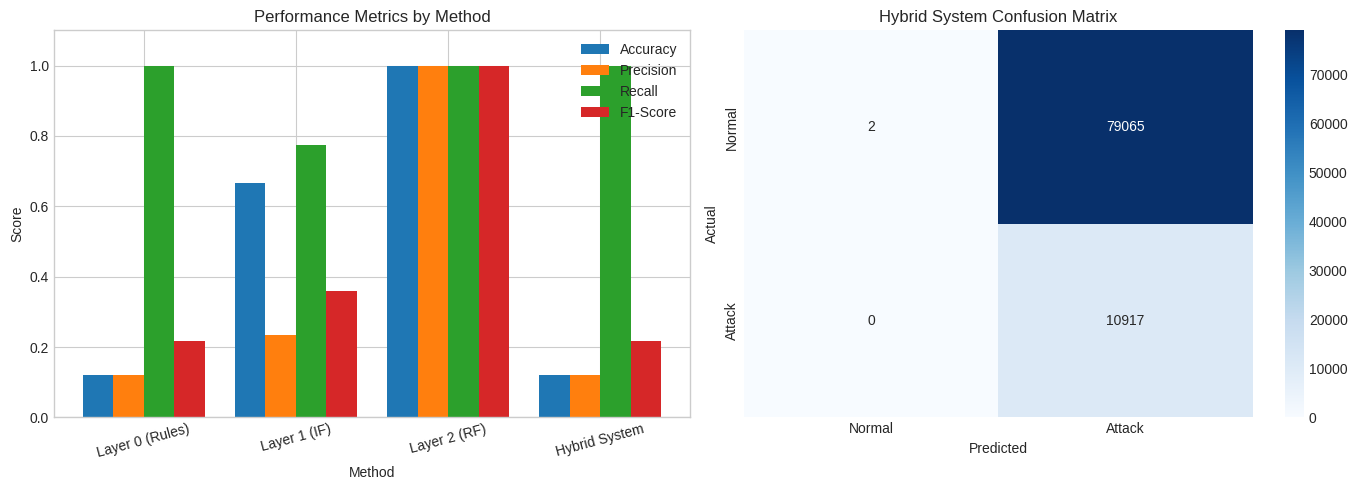

Saved: hybrid_performance.png


In [21]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Metrics comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(results_df))
width = 0.2

for i, metric in enumerate(metrics):
    axes[0].bar(x + i*width, results_df[metric], width, label=metric)

axes[0].set_xlabel('Method')
axes[0].set_ylabel('Score')
axes[0].set_title('Performance Metrics by Method')
axes[0].set_xticks(x + width * 1.5)
axes[0].set_xticklabels(results_df['Method'], rotation=15)
axes[0].legend()
axes[0].set_ylim(0, 1.1)

# Plot 2: Confusion matrix for hybrid
cm = confusion_matrix(y_test, hybrid_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'],
            ax=axes[1])
axes[1].set_title('Hybrid System Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.savefig('hybrid_performance.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: hybrid_performance.png")

In [22]:
# Detailed classification report for hybrid system
print("\n" + "="*60)
print("HYBRID SYSTEM CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, hybrid_binary, target_names=['Normal', 'Attack']))


HYBRID SYSTEM CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Normal       1.00      0.00      0.00     79067
      Attack       0.12      1.00      0.22     10917

    accuracy                           0.12     89984
   macro avg       0.56      0.50      0.11     89984
weighted avg       0.89      0.12      0.03     89984



---
## Step 10: Save Models

In [23]:
import os

# Create directory if it doesn't exist
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

# Save all components
joblib.dump(scaler, f'{MODEL_SAVE_PATH}/scaler.pkl')
joblib.dump(isolation_forest, f'{MODEL_SAVE_PATH}/isolation_forest.pkl')
joblib.dump(random_forest, f'{MODEL_SAVE_PATH}/random_forest.pkl')
joblib.dump(rule_detector, f'{MODEL_SAVE_PATH}/rule_detector.pkl')
joblib.dump(sensor_cols, f'{MODEL_SAVE_PATH}/feature_columns.pkl')

print("✅ Models saved:")
print(f"   - {MODEL_SAVE_PATH}/scaler.pkl")
print(f"   - {MODEL_SAVE_PATH}/isolation_forest.pkl")
print(f"   - {MODEL_SAVE_PATH}/random_forest.pkl")
print(f"   - {MODEL_SAVE_PATH}/rule_detector.pkl")
print(f"   - {MODEL_SAVE_PATH}/feature_columns.pkl")

✅ Models saved:
   - /content/drive/MyDrive/4th7thsemproject/models//scaler.pkl
   - /content/drive/MyDrive/4th7thsemproject/models//isolation_forest.pkl
   - /content/drive/MyDrive/4th7thsemproject/models//random_forest.pkl
   - /content/drive/MyDrive/4th7thsemproject/models//rule_detector.pkl
   - /content/drive/MyDrive/4th7thsemproject/models//feature_columns.pkl


---
## Step 11: Real-Time Simulation

In [24]:
def simulate_realtime_detection(detector, data, batch_size=10, delay=0.1):
    """
    Simulate real-time detection by processing data in batches.
    """
    print("\n" + "="*60)
    print("REAL-TIME SIMULATION")
    print("="*60)
    print(f"Processing {len(data):,} samples in batches of {batch_size}")
    print("-"*60)

    total_alerts = {'Normal': 0, 'Low': 0, 'Medium': 0, 'High': 0, 'Critical': 0}
    n_batches = min(10, len(data) // batch_size)  # Limit for demo

    for batch_num in range(n_batches):
        start_idx = batch_num * batch_size
        end_idx = start_idx + batch_size
        batch = data[start_idx:end_idx]

        # Process batch
        start_time = time.time()
        predictions, details = detector.predict(batch, return_details=True)
        process_time = (time.time() - start_time) * 1000  # Convert to ms

        # Count alerts
        n_anomalies = predictions.sum()

        # Update totals
        alert_names = ['Normal', 'Low', 'Medium', 'High', 'Critical']
        for level, name in enumerate(alert_names):
            total_alerts[name] += (details['alert_levels'] == level).sum()

        # Print batch results
        status = "⚠️ ALERT" if n_anomalies > 0 else "✅ OK"
        print(f"Batch {batch_num+1:3d} | {status} | Anomalies: {int(n_anomalies):2d}/{batch_size} | Time: {process_time:.1f}ms")

        time.sleep(delay)  # Simulate real-time delay

    print("-"*60)
    print("\nTotal Alert Summary:")
    for level, count in total_alerts.items():
        if count > 0:
            print(f"  {level}: {count}")

# Run simulation
simulate_realtime_detection(hybrid_detector, X_test, batch_size=100, delay=0.5)


REAL-TIME SIMULATION
Processing 89,984 samples in batches of 100
------------------------------------------------------------
Batch   1 | ⚠️ ALERT | Anomalies: 100/100 | Time: 2.4ms
Batch   2 | ⚠️ ALERT | Anomalies: 100/100 | Time: 1.5ms
Batch   3 | ⚠️ ALERT | Anomalies: 100/100 | Time: 2.1ms
Batch   4 | ⚠️ ALERT | Anomalies: 100/100 | Time: 2.1ms
Batch   5 | ⚠️ ALERT | Anomalies: 100/100 | Time: 2.1ms
Batch   6 | ⚠️ ALERT | Anomalies: 100/100 | Time: 2.1ms
Batch   7 | ⚠️ ALERT | Anomalies: 100/100 | Time: 2.1ms
Batch   8 | ⚠️ ALERT | Anomalies: 100/100 | Time: 1.5ms
Batch   9 | ⚠️ ALERT | Anomalies: 100/100 | Time: 1.8ms
Batch  10 | ⚠️ ALERT | Anomalies: 100/100 | Time: 1.6ms
------------------------------------------------------------

Total Alert Summary:
  Critical: 1000


---
## Summary

In [25]:
print("\n" + "="*70)
print("HYBRID ANOMALY DETECTION SYSTEM - SUMMARY")
print("="*70)

print("""
📊 ARCHITECTURE:

┌─────────────────────────────────────────────────────────────────┐
│                     SCADA Data Input                            │
└─────────────────────────────┬───────────────────────────────────┘
                              ▼
┌─────────────────────────────────────────────────────────────────┐
│  LAYER 0: Rule-Based Detection (<1ms)                          │
│  • Physical limit violations                                    │
│  • Rate of change anomalies                                     │
│  → CRITICAL ALERT if triggered                                  │
└─────────────────────────────┬───────────────────────────────────┘
                              ▼ (if passes)
┌─────────────────────────────────────────────────────────────────┐
│  LAYER 1: Isolation Forest (~10ms)                             │
│  • Unsupervised anomaly detection                              │
│  • Trained on normal data only                                 │
│  • Can detect zero-day attacks                                 │
│  → Flags statistical anomalies                                 │
└─────────────────────────────┬───────────────────────────────────┘
                              ▼ (if anomaly)
┌─────────────────────────────────────────────────────────────────┐
│  LAYER 2: Random Forest (~5ms)                                 │
│  • Supervised classification                                    │
│  • Classifies attack type                                      │
│  • Provides confidence score                                   │
│  → HIGH/MEDIUM alert based on confidence                       │
└─────────────────────────────┬───────────────────────────────────┘
                              ▼
┌─────────────────────────────────────────────────────────────────┐
│                    Alert Management                             │
└─────────────────────────────────────────────────────────────────┘
""")

print("\n📈 PERFORMANCE RESULTS:")
print(results_df.to_string(index=False))

print("\n✅ ADVANTAGES OF HYBRID APPROACH:")
print("   1. Rule-based catches obvious violations instantly")
print("   2. Isolation Forest detects novel attacks (no labels needed)")
print("   3. Random Forest classifies known attacks with high accuracy")
print("   4. Multi-level alerts help prioritize operator response")
print("   5. Cascading design reduces computational load")

print("\n" + "="*70)


HYBRID ANOMALY DETECTION SYSTEM - SUMMARY

📊 ARCHITECTURE:

┌─────────────────────────────────────────────────────────────────┐
│                     SCADA Data Input                            │
└─────────────────────────────┬───────────────────────────────────┘
                              ▼
┌─────────────────────────────────────────────────────────────────┐
│  LAYER 0: Rule-Based Detection (<1ms)                          │
│  • Physical limit violations                                    │
│  • Rate of change anomalies                                     │
│  → CRITICAL ALERT if triggered                                  │
└─────────────────────────────┬───────────────────────────────────┘
                              ▼ (if passes)
┌─────────────────────────────────────────────────────────────────┐
│  LAYER 1: Isolation Forest (~10ms)                             │
│  • Unsupervised anomaly detection                              │
│  • Trained on normal data only                  